In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

(array([ 1.,  0.,  1.,  0.,  1.,  4.,  4.,  4.,  7.,  9.,  7., 13., 10.,
        22., 16., 24., 24., 25., 35., 34., 41., 31., 45., 52., 46., 67.,
        64., 55., 40., 32., 33., 33., 40., 20., 22., 31., 16.,  9., 11.,
        12., 18.,  6.,  9., 10.,  5.,  3.,  1.,  2.,  4.,  1.]),
 array([-35.72381098, -34.33709832, -32.95038566, -31.563673  ,
        -30.17696034, -28.79024769, -27.40353503, -26.01682237,
        -24.63010971, -23.24339706, -21.8566844 , -20.46997174,
        -19.08325908, -17.69654642, -16.30983377, -14.92312111,
        -13.53640845, -12.14969579, -10.76298314,  -9.37627048,
         -7.98955782,  -6.60284516,  -5.2161325 ,  -3.82941985,
         -2.44270719,  -1.05599453,   0.33071813,   1.71743078,
          3.10414344,   4.4908561 ,   5.87756876,   7.26428142,
          8.65099407,  10.03770673,  11.42441939,  12.81113205,
         14.1978447 ,  15.58455736,  16.97127002,  18.35798268,
         19.74469534,  21.13140799,  22.51812065,  23.90483331,
         25.

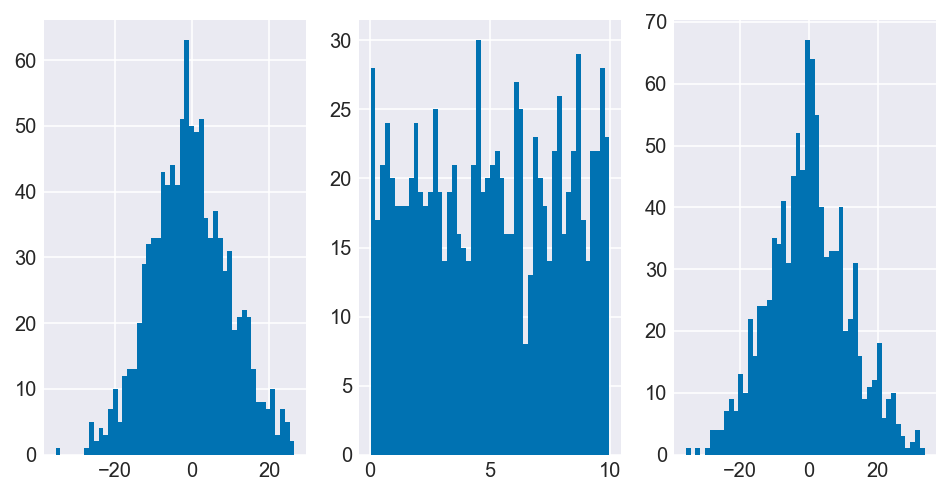

In [11]:
# 4M1
# Simulating priors
mu_samples = np.random.normal(0, 10, size=1000)
sigma_samples = np.random.uniform(0.0,10, size=1000)
y = np.random.normal(mu_samples, sigma_samples)

_, axes = plt.subplots(1,3, figsize=(8,4))
axes[0].hist(mu_samples, histtype='stepfilled', bins=50)
axes[1].hist(sigma_samples, histtype='stepfilled', bins=50)
axes[2].hist(y, histtype='stepfilled', bins=50)

In [48]:
# 4H1

individual = list(range(1, 6))
weight = (46.95, 43.72, 64.78, 32.59, 54.63)
weight_df=pd.DataFrame({
    'individual':individual,
    'weight':weight,
})
d = pd.read_csv('../Data/Howell1.csv', sep=';', header=0)
d = d[d.age >= 18]
d['weight_c'] = d.weight - d.weight.mean() 
print(d.head())
print(weight_df.head())

    height     weight   age  male   weight_c
0  151.765  47.825606  63.0     1   2.835121
1  139.700  36.485807  63.0     0  -8.504679
2  136.525  31.864838  65.0     0 -13.125648
3  156.845  53.041915  41.0     1   8.051429
4  145.415  41.276872  51.0     0  -3.713614
   individual  weight
0           1   46.95
1           2   43.72
2           3   64.78
3           4   32.59
4           5   54.63


In [71]:
with pm.Model() as m_4h1:
    alpha = pm.Normal('alpha',mu=140,sd=30)
    beta = pm.Normal('beta',mu=0,sd=10)
    # mu=alpha+beta*d.weight_c
    mu = pm.Deterministic('mu', alpha + beta * d.weight)
    sigma=pm.Uniform('sigma',lower=0,upper=50)
    height=pm.Normal('height',mu=mu,sd=sigma,observed=d.height)
    trace_4h1=pm.sample(1000,tune=1000)
    
# Questions
# What is alpha? when centered, it is weight at 0, but what is it when it is not centered?
# What is the sigma in Alpha? What is the Sigma in the formula?
# How do I determine the mu and sd for Beta?
# What is the right way to use the model for prediction, do we need to sample from posterior for the new inputs?
# sample_posterior_predictive()?


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 4000/4000 [00:08<00:00, 313.50draws/s]


In [72]:
pm.summary(trace_4h1, alpha=.11,varnames=['alpha','beta','sigma']).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,114.10,1.89,0.07,111.25,117.12,787.88,1.0
beta,0.90,0.04,0.00,0.83,0.96,804.15,1.0
sigma,5.11,0.20,0.01,4.76,5.40,748.69,1.0


In [73]:
def f(x):
    y=trace_4h1['alpha'].mean()+trace_4h1['beta'].mean()*x
    return y
def f_min(x):
    y=pm.hpd(trace_4h1['alpha'],0.11)[0]+pm.hpd(trace_4h1['beta'],0.11)[0]*x
    return y

def f_max(x):
    y=pm.hpd(trace_4h1['alpha'],0.11)[1]+pm.hpd(trace_4h1['beta'],0.11)[1]*x
    return y

weight_df['height'] = weight_df['weight'].apply(f)
weight_df['height_5.5'] = weight_df['weight'].apply(f_min)
weight_df['height_94.5'] = weight_df['weight'].apply(f_max)

In [74]:
weight_df

,individual,weight,height,height_5.5,height_94.5
0,1,46.95,156.362889,150.431053,162.355759
1,2,43.72,153.455338,147.735811,159.243657
2,3,64.78,172.412930,165.309122,179.534942
3,4,32.59,143.436440,138.448491,148.519916
4,5,54.63,163.276199,156.839554,169.755429


array([110.74260708, 117.2044711 ])

In [76]:
d.height.mean()

154.5970926136364